In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## Reading Books with Data Science Part 2: Knowledge Retrieval, Relation Mining, and Community Detection in the Lord of the Rings

I have a deep passion for both data science and fantasy literature. When I came across the Witcher dataset on Kaggle, I was immediately inspired and filled with ideas for exploratory data analysis. However, to dive deeper into the data, I realized I needed to create an extended version of the dataset.

Exploring interesting data is a great motivator for learning new concepts. To analyze characters and their relationships from books effectively, it’s essential to understand the **basics of graph analysis**.

That's why today, I want to share my dataset and tell about graph analysis.
This post is organized into the following sections:
0. Short description of how I built my extended dataset.
1. General analysis, including approaches for identifying main characters, examining their relationships, and exploring text data through words cloud.
This section covers:
    - Key components of a graph
    - Types of graphs
    - Graph measures
2. Approaches to community detection and how they reveal hidden structures in the narrative. This section covers:
    - Louvain Method
    - Girvan-Newman Algorithm

Let’s dive into this exciting mix of data science and storytelling!


# Dataset preparation
The complete code is available in my GitHub repository, but here’s a brief overview of the process:

1. Identify the main characters and create a list of name pairs.Each name will represent a graph node later.
2. Extract text fragments where each pair of characters is mentioned together.
3. Use the Huggingface pipeline("sentiment-analysis") to classify each fragment as positive or negative.
4. Apply the distilbert-base-uncased-emotion model to classify each fragment's emotions.  

I used default parameters and performed minimal text cleaning, so there’s plenty of room for improvement in this approach.

# General analysis

## Graph Analysis
Here are some main concepts:

### Key Components of a Graph:
- Nodes (or Vertices) - represent entities or items (e.g., people, cities).
- Edges - represent connections or relationships between nodes. Edges can be:
directed (one-way connection, e.g., "follows") or undirected (mutual relationship).
- Weight - assigned a value indicating the strength or importance of the connection (e.g., frequency of interaction).

### Types of Graphs
- Undirected Graph: Connections are bidirectional (e.g., friendship).
- Directed Graph (Digraph): Connections have a direction (e.g., hyperlinks).
- Weighted Graph: Edges have weights (e.g., road distances).
- Bipartite Graph: Nodes are divided into two distinct sets, with edges only between sets (e.g., users and products).



Now we are ready to start analysis!
Here is the final version of the dataset:

In [ ]:
lotr_network = pd.read_csv("lotr_network_classified_final.csv")
lotr_network.head()

,Unnamed: 0,phrases,label,emotion,book,person_1,person_2
0,0,"They moved to a clump of trees, and though it...",NEGATIVE,anger,hobbit,Gloin,Fili
1,1,He got into the river before they could catch...,NEGATIVE,anger,hobbit,Gloin,Fili
2,2,"As each dwarf came up and looked at the fire, ...",NEGATIVE,anger,hobbit,Gloin,Fili
3,3,You would have laughed (from a safe distance)...,NEGATIVE,fear,hobbit,Gloin,Fili
4,4,It is lying on the boat; let’s hope the hook ...,NEGATIVE,sadness,hobbit,Gloin,Fili


## Calculate agregated features

For the analysis, I need aggregated values for each character pair. This includes preparing one-hot encoded columns for sentiment (negative, positive) and each emotion, along with a "weight" column representing the total number of phrases for each pair. Also I add a column "connection_label" which is calculated as (sum of positive phrases - sum of negative phrases)/(sum of positive phrases + sum of negative phrases)

In [ ]:
df_labels= pd.get_dummies(lotr_network, columns=['label', 'emotion'], dtype='int')

In [ ]:
df_rel_grouped = df_labels.groupby(['person_1', 'person_2'])[['label_NEGATIVE',
       'label_POSITIVE', 'emotion_anger', 'emotion_fear', 'emotion_joy',
       'emotion_love', 'emotion_sadness', 'emotion_surprise']].sum().reset_index()

df_rel_grouped['connection_label'] = (df_rel_grouped['label_POSITIVE'] - df_rel_grouped['label_NEGATIVE'])/(df_rel_grouped['label_POSITIVE'] + df_rel_grouped['label_NEGATIVE'])
df_rel_grouped['weight'] = df_rel_grouped['label_POSITIVE'] + df_rel_grouped['label_NEGATIVE']
df_rel_grouped.sort_values(by = 'connection_label').head(2)



,person_1,person_2,label_NEGATIVE,label_POSITIVE,emotion_anger,emotion_fear,emotion_joy,emotion_love,emotion_sadness,emotion_surprise,connection_label,weight
141,Gaffer,Gandalf,3,0,2,1,0,0,0,0,-1.0,3
205,Lotho,Saruman,3,0,1,1,1,0,0,0,-1.0,3


In [ ]:
## hard to analyse, lets get more heavy
df_rel_grouped_short = df_rel_grouped.query('weight >3')
df_rel_grouped_short.shape

(264, 12)

The first step in the analysis is creating a graph. For graph analysis, I use the NetworkX library. The graph is constructed as an using the from_pandas_edgelist method with data from a pandas DataFrame (nodes - characters). G is an undirected graph where characters - nodes are connected to each other.

Additionally, I highlighted more important characters by plotting them with larger circles. How their importance is calculated will be explained later in this post.

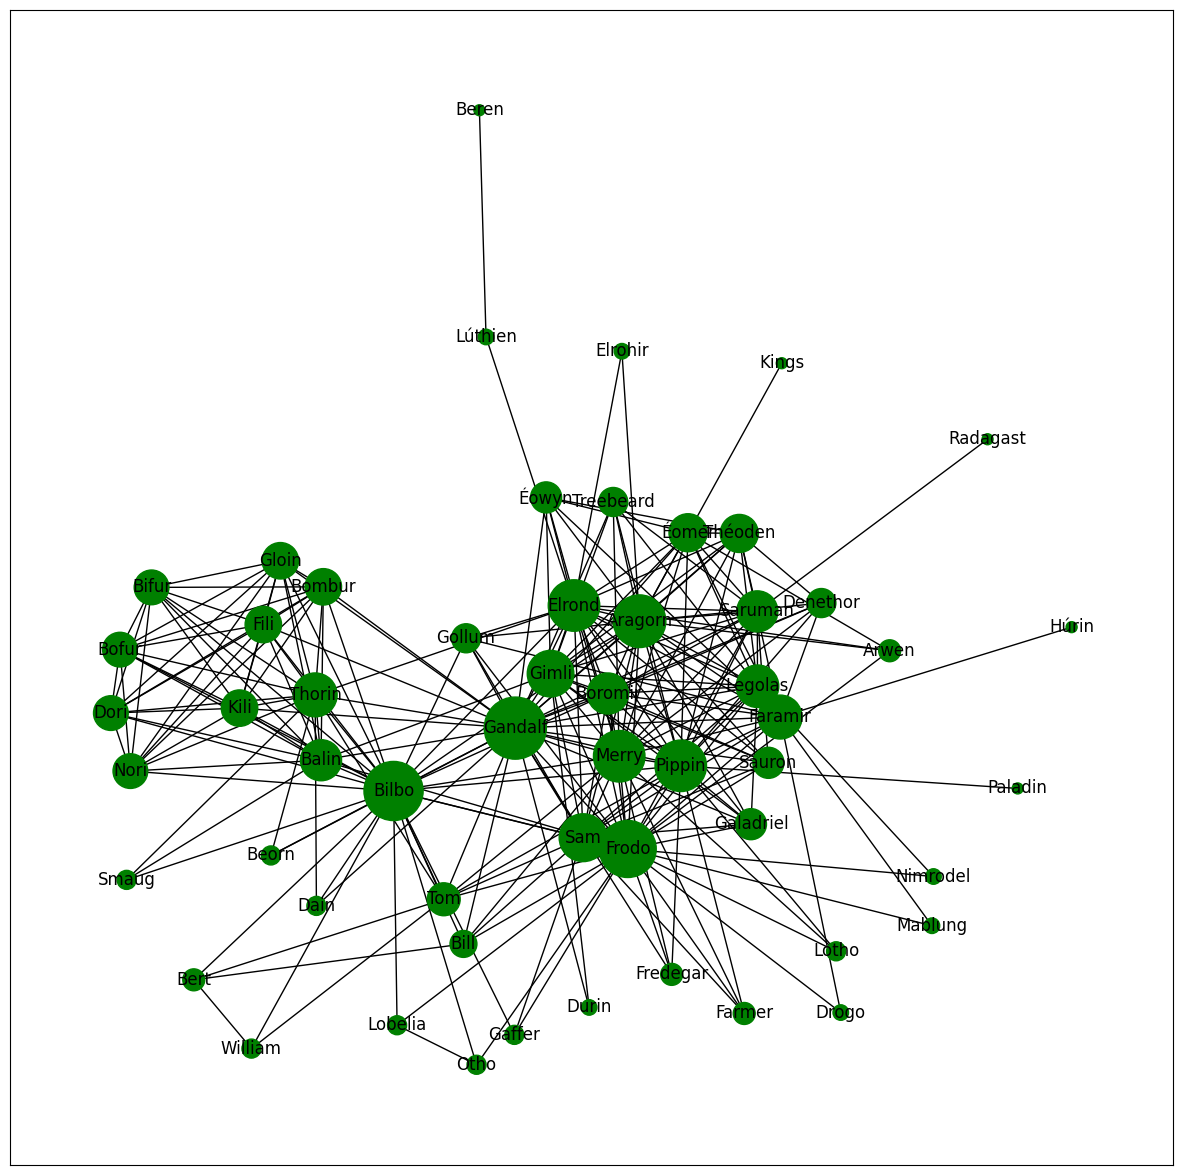

In [ ]:
G = nx.Graph()

G = nx.from_pandas_edgelist(df_rel_grouped_short, 'person_1', 'person_2', edge_attr='connection_label')

deg_centrality = nx.degree_centrality(G)
cent = np.fromiter(deg_centrality.values(), float)
sizes = cent / np.max(cent) * 200

plt.figure(figsize=(15,15))

pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G,pos, with_labels=True, node_color='g', node_size=sizes*10)
plt.show()

## Graph Centrality Measures. How to find out who is the main character?

1. Degree centrality is a measure of the importance or influence of a node in a network, based on how many direct connections (edges) it has. It is one of the simplest and most intuitive metrics in network analysis.

2. Betweenness centrality is a measure of how often a node lies on the shortest paths between other nodes in a network. It reflects the node's role as a bridge or intermediary, helping to connect different parts of the network. Nodes with high betweenness centrality are critical for the flow of information, resources, or influence.

3. Eigenvector centrality measures a node's influence in a network by considering both the number of its connections and the importance of the nodes it is connected to. Unlike simpler metrics like degree centrality, which only count direct connections, eigenvector centrality evaluates the quality of those connections, giving higher weight to connections with influential nodes.

In [ ]:
G = nx.from_pandas_edgelist(df_rel_grouped, 'person_1', 'person_2', edge_attr='connection_label')

deg_centrality = nx.degree_centrality(G)
cent = np.fromiter(deg_centrality.values(), float)

print('Degree centrality')
dict(sorted(deg_centrality.items(), key=lambda item: item[1], reverse=True)[:10])

Degree centrality


{'Frodo': 0.53125,
 'Gandalf': 0.515625,
 'Bilbo': 0.5,
 'Merry': 0.40625,
 'Aragorn': 0.390625,
 'Elrond': 0.375,
 'Pippin': 0.375,
 'Sam': 0.328125,
 'Balin': 0.296875,
 'Gimli': 0.28125}

In [ ]:
print('Betweenness centrality')
betweenness = nx.betweenness_centrality(G)
dict(sorted(betweenness.items(), key=lambda item: item[1], reverse=True)[:10])

Betweenness centrality


{'Bilbo': 0.21286044252358244,
 'Frodo': 0.173084532338423,
 'Gandalf': 0.13375918906571135,
 'Elrond': 0.10539204742330895,
 'Aragorn': 0.06850938805290448,
 'Merry': 0.06763449272542547,
 'Pippin': 0.06085949721394032,
 'Sam': 0.050385648864843174,
 'Thorin': 0.03871700291115097,
 'Balin': 0.03848772339945123}

In [ ]:
print('Eigenvector centrality')
eigenvector = nx.eigenvector_centrality(G)
dict(sorted(eigenvector.items(), key=lambda item: item[1], reverse=True)[:10])

Eigenvector centrality


{'Gandalf': 0.2969539396806616,
 'Frodo': 0.28011346325499925,
 'Aragorn': 0.2537814617875778,
 'Merry': 0.2535603242524152,
 'Pippin': 0.23875328059909298,
 'Elrond': 0.23800566719513574,
 'Bilbo': 0.21797230990467265,
 'Sam': 0.21324824846274817,
 'Gimli': 0.21105572903721123,
 'Legolas': 0.20862987813790257}

Acoording to these metrics main characters are Bilbo, Gendalf and Frodo!

Let's examine how degree centrality measures for main characters  evolves from one book to another. Observing its changes across books can reveal how the importance or influence of characters shifts throughout the story. Observing its changes across books can reveal how the importance or influence of characters shifts throughout the story
For that we need:
- Construct individual graphs for each book
- Calculate degree centrality for each graph

In [ ]:
## Importance in book
books = ["hobbit",
        "The Fellowship Of The Ring", "The Two Towers", "The Return Of The King"]

df_rel_grouped_books = df_labels.groupby(['book', 'person_1', 'person_2'])[['label_NEGATIVE',
       'label_POSITIVE', 'emotion_anger', 'emotion_fear', 'emotion_joy',
       'emotion_love', 'emotion_sadness', 'emotion_surprise']].sum().reset_index()

df_rel_grouped_books['connection_label'] = (df_rel_grouped_books['label_POSITIVE'] - df_rel_grouped_books['label_NEGATIVE'])/(df_rel_grouped_books['label_POSITIVE'] + df_rel_grouped_books['label_NEGATIVE'])
df_rel_grouped_books['weight'] = df_rel_grouped_books['label_POSITIVE'] + df_rel_grouped_books['label_NEGATIVE']


In [ ]:
graph_books_list = []

for i in books:
    tmp = df_rel_grouped_books.query("book == @i")
    G_tmp = nx.from_pandas_edgelist(tmp, 'person_1', 'person_2', edge_attr='connection_label')
    graph_books_list.append(G_tmp)

In [ ]:
degree_centrality_books = [nx.degree_centrality(book) for book in graph_books_list]
df_dgr_books = pd.DataFrame(degree_centrality_books)

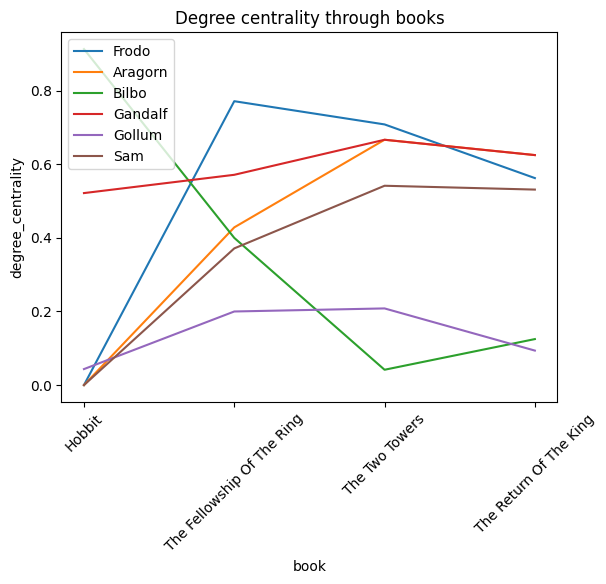

In [ ]:
df_dgr_books.fillna(0, inplace = True)

sns.lineplot(data=df_dgr_books, x=df_dgr_books.index, y="Frodo", label = "Frodo")
sns.lineplot(data=df_dgr_books, x=df_dgr_books.index, y="Aragorn", label = "Aragorn")
sns.lineplot(data=df_dgr_books, x=df_dgr_books.index, y="Bilbo", label = "Bilbo")
sns.lineplot(data=df_dgr_books, x=df_dgr_books.index, y="Gandalf", label = "Gandalf")
sns.lineplot(data=df_dgr_books, x=df_dgr_books.index, y="Gollum", label = "Gollum")
sns.lineplot(data=df_dgr_books, x=df_dgr_books.index, y="Sam", label = "Sam")


tick_positions = [0, 1, 2, 3]
tick_labels = ["Hobbit",
        "The Fellowship Of The Ring", "The Two Towers", "The Return Of The King"]
plt.xticks(tick_positions, tick_labels, rotation=45)
plt.xlabel('book')
plt.ylabel('degree_centrality')
plt.title('Degree centrality through books')
plt.legend()

## Relation Mining

Now we have a list of main characters and can analyse their relationships(I decided to add Dandelion to this list)


In [ ]:
main_characters = ['Frodo', 'Gandalf', 'Aragorn', 'Sam']


In [ ]:
## the worst relationships
cols = ['person_1', 'person_2', 'label_NEGATIVE', 'label_POSITIVE', 'connection_label']
df_rel_grouped_short[cols].sort_values(by = 'connection_label').head(3)


,person_1,person_2,label_NEGATIVE,label_POSITIVE,connection_label
274,Thorin,Tom,4,0,-1.0
37,Bert,Tom,11,0,-1.0
38,Bert,William,13,0,-1.0


In [ ]:
## the best relationships
df_rel_grouped_short[cols].sort_values(by = 'connection_label').tail(3)


,person_1,person_2,label_NEGATIVE,label_POSITIVE,connection_label
208,Mablung,Faramir,0,4,1.0
300,Éowyn,Elrond,0,4,1.0
303,Éowyn,Gimli,0,4,1.0


## Get character relationships

In [ ]:
def tell_a_general_story(main_character):
    print(f'Story about {main_character}')
    print('-'*10)
    d1 = df_rel_grouped_short.query(f"person_1 == '{main_character}'")
    d2 = df_rel_grouped_short.query(f"person_2 == '{main_character}'")

    if d2.shape[0] > 0:
        pers1 = d2["person_1"]
        d2["person_1"] = main_character
        d2["person_2"] = pers1

    rel_analysis = pd.concat([d1, d2], axis = 0)

    less_phrases = list(rel_analysis[cols + ['weight']].sort_values(by = 'weight').head(5)['person_2'])
    most_phrases = list(rel_analysis[cols + ['weight']].sort_values(by = 'weight').tail(5)['person_2'])

    print(f"{main_character}  has the fewest interactions with {less_phrases}")
    print(f"{main_character} has min interactions with {less_phrases[0]}")
    print('-'*10)
    print(f"{main_character} interacts most frequently with {most_phrases}")
    print(f"{main_character} has max interactions with {most_phrases[-1]}")
    print('-'*10)

    negative_phrases = list(rel_analysis[cols].sort_values(by = 'connection_label').head(5)['person_2'])
    positive_phrases = list(rel_analysis[cols].sort_values(by = 'connection_label').tail(5)['person_2'])

    print(f"{main_character} has the most negative interactions with {negative_phrases}")
    print(f"{main_character} has the most negative one with {negative_phrases[0]}")
    print('-'*10)
    print(f"{main_character} has the most positive interaction with {positive_phrases}")
    print(f"{main_character} has the most positive one with {positive_phrases[-1]}")
    print('-'*10)

    emotions = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
    for i in emotions:
        rel_analysis[i] = rel_analysis[f'emotion_{i}']/rel_analysis['weight']
        lst_emotion = list(rel_analysis[['person_1', 'person_2', i]].sort_values(by = i).tail(4)['person_2'])
        print(f"{main_character} feels the most {i} toward {lst_emotion}")
    print('-'*10)

    return rel_analysis


def tell_relationships_with_main(main_character, rel_analysis):
    main_ch = main_characters
    main_ch.remove(main_character)
    ch_for_analysis = main_ch + add_persons

    rel_with_main = rel_analysis.query(f'person_2 in {ch_for_analysis}')

    plt.barh(rel_with_main.person_2, rel_with_main.anger, color='#D32F2F', label='anger')
    plt.barh(rel_with_main.person_2, rel_with_main.fear, left= rel_with_main.anger, color='#7B1FA2', label='fear')
    plt.barh(rel_with_main.person_2, rel_with_main.joy, left= rel_with_main.fear + rel_with_main.anger, color='#FFEB3B', label='joy')
    plt.barh(rel_with_main.person_2, rel_with_main.love, left=rel_with_main.fear + rel_with_main.anger + rel_with_main.joy, color='#E91E63', label='love')
    plt.barh(rel_with_main.person_2, rel_with_main.sadness, left=rel_with_main.fear + rel_with_main.anger + rel_with_main.joy + rel_with_main.love, color='#2196F3', label='sadness')
    plt.barh(rel_with_main.person_2, rel_with_main.surprise, left=rel_with_main.fear + rel_with_main.anger + rel_with_main.joy + rel_with_main.love + rel_with_main.sadness, color='#FFA726', label='surprise')

    plt.xlabel("fraction")
    plt.ylabel("Characters")
    plt.title(f"{main_character} relationships with others")
    plt.legend()

    plt.show()


def plot_word_cloud(df, title_str, name_1, name_2):
    combined_text = ' '.join(df['phrases'])

    combined_text = combined_text.replace(name_1, "").replace(name_2, "").replace("will", "").replace("said", "")

    wordcloud_img = WordCloud(width = 800, height = 800,
                                background_color ='white', colormap = 'tab10',
                                min_font_size = 10).generate(combined_text)

    plt.figure(figsize=(5,5))
    plt.imshow(wordcloud_img)
    plt.axis('off')
    plt.title(title_str)
    plt.tight_layout(pad=2)
    plt.show()

In [ ]:
main_character = "Frodo"
df = tell_a_general_story(main_character)

Story about Frodo
----------
Frodo  has the fewest interactions with ['Nimrodel', 'Otho', 'Balin', 'Fredegar', 'Lotho']
Frodo has min interactions with Nimrodel
----------
Frodo interacts most frequently with ['Gollum', 'Bilbo', 'Pippin', 'Gandalf', 'Sam']
Frodo has max interactions with Sam
----------
Frodo has the most negative interactions with ['Lobelia', 'Bill', 'Balin', 'Otho', 'Legolas']
Frodo has the most negative one with Lobelia
----------
Frodo has the most positive interaction with ['Galadriel', 'Elrond', 'Drogo', 'Tom', 'Arwen']
Frodo has the most positive one with Arwen
----------
Frodo feels the most anger toward ['Sauron', 'Lobelia', 'Otho', 'Balin']
Frodo feels the most fear toward ['Sam', 'Bill', 'Gollum', 'Balin']
Frodo feels the most joy toward ['Galadriel', 'Fredegar', 'Tom', 'Arwen']
Frodo feels the most love toward ['Arwen', 'Fredegar', 'Drogo', 'Farmer']
Frodo feels the most sadness toward ['Gaffer', 'Gimli', 'Legolas', 'Bill']
Frodo feels the most surprise towa

<ipython-input-34-7f114bd53b29>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2["person_1"] = main_character
<ipython-input-34-7f114bd53b29>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2["person_2"] = pers1


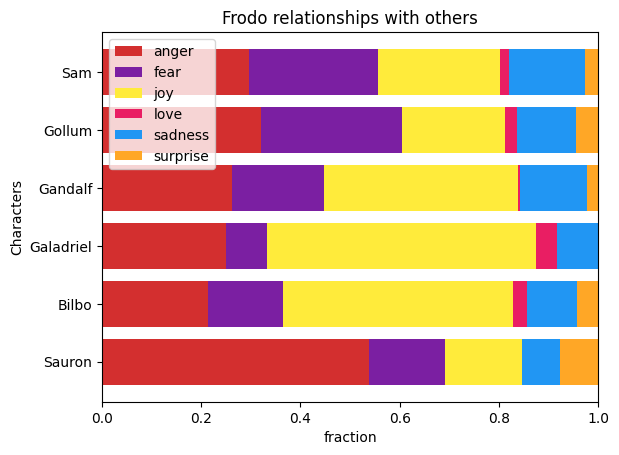

In [ ]:
add_persons = ['Galadriel', 'Gollum', 'Bilbo', 'Sauron']
## main_characters = ['Frodo', 'Gandalf', 'Aragorn', 'Sam']
tell_relationships_with_main(main_character, df)

In [ ]:
main_character = "Aragorn"
df = tell_a_general_story(main_character)

Story about Aragorn
----------
Aragorn  has the fewest interactions with ['Elrohir', 'Bilbo', 'Arwen', 'Gollum', 'Galadriel']
Aragorn has min interactions with Elrohir
----------
Aragorn interacts most frequently with ['Boromir', 'Frodo', 'Gandalf', 'Legolas', 'Gimli']
Aragorn has max interactions with Gimli
----------
Aragorn has the most negative interactions with ['Gollum', 'Boromir', 'Merry', 'Saruman', 'Sauron']
Aragorn has the most negative one with Gollum
----------
Aragorn has the most positive interaction with ['Éowyn', 'Elrond', 'Faramir', 'Arwen', 'Kings']
Aragorn has the most positive one with Kings
----------
Aragorn feels the most anger toward ['Saruman', 'Théoden', 'Treebeard', 'Arwen']
Aragorn feels the most fear toward ['Sam', 'Gimli', 'Denethor', 'Gollum']
Aragorn feels the most joy toward ['Arwen', 'Merry', 'Kings', 'Elrohir']
Aragorn feels the most love toward ['Merry', 'Pippin', 'Faramir', 'Kings']
Aragorn feels the most sadness toward ['Galadriel', 'Sam', 'Faramir

<ipython-input-34-7f114bd53b29>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2["person_1"] = main_character
<ipython-input-34-7f114bd53b29>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2["person_2"] = pers1


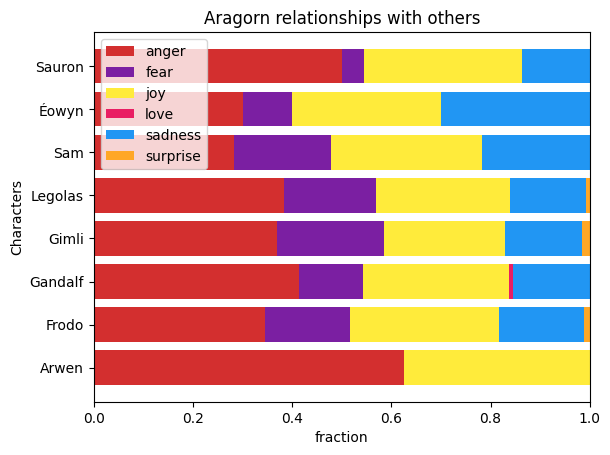

In [ ]:
add_persons = ['Arwen', 'Éowyn', 'Legolas', 'Gimli', 'Sauron']
main_characters = ['Frodo', 'Gandalf', 'Aragorn', 'Sam']
tell_relationships_with_main(main_character, df)

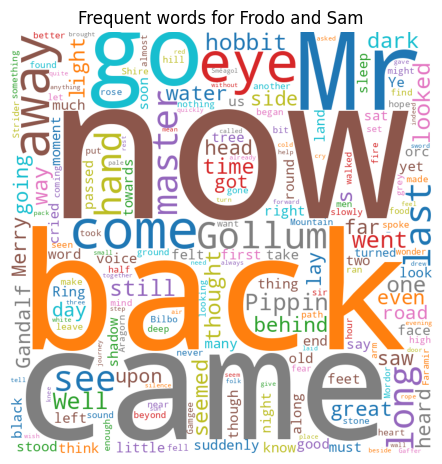

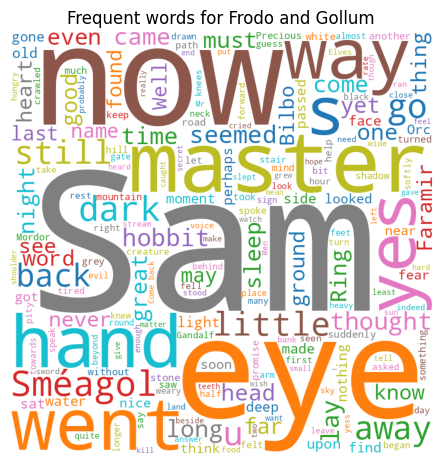

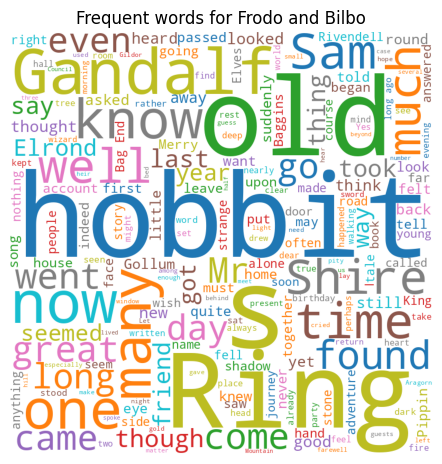

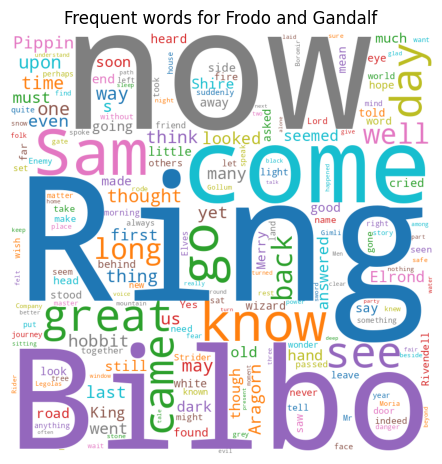

In [ ]:
main_character = 'Frodo'
words_cloud_ch = ['Sam', 'Gollum', 'Bilbo', 'Gandalf']

for person2 in words_cloud_ch:
    df1 = lotr_network.query(f"person_1 == '{main_character}' and person_2 == '{person2}'")
    df2 = lotr_network.query(f"person_2 == '{main_character}' and person_1 == '{person2}'")

    df = pd.concat([df1, df2], axis = 0)

    plot_word_cloud(df, f'Frequent words for {main_character} and {person2}', main_character, person2)

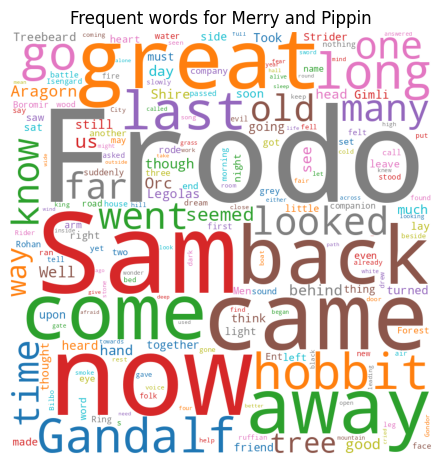

In [ ]:
main_character = 'Merry'
words_cloud_ch = ['Pippin']

for person2 in words_cloud_ch:
    df1 = lotr_network.query(f"person_1 == '{main_character}' and person_2 == '{person2}'")
    df2 = lotr_network.query(f"person_2 == '{main_character}' and person_1 == '{person2}'")

    df = pd.concat([df1, df2], axis = 0)

    plot_word_cloud(df, f'Frequent words for {main_character} and {person2}', main_character, person2)

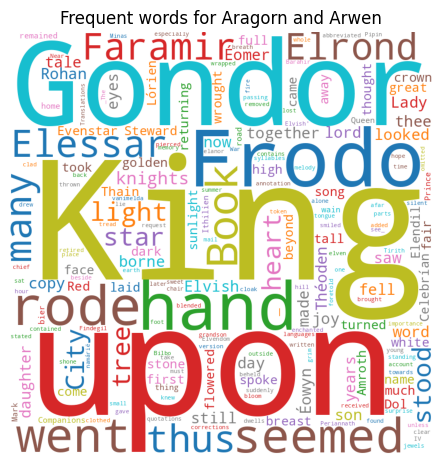

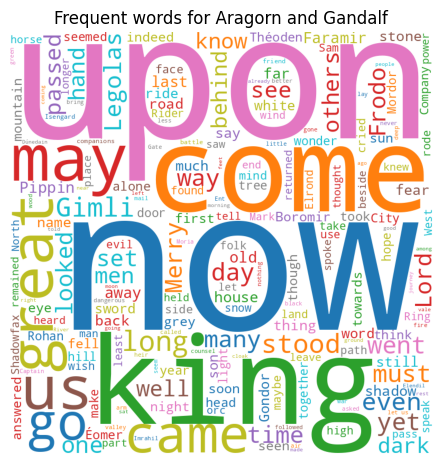

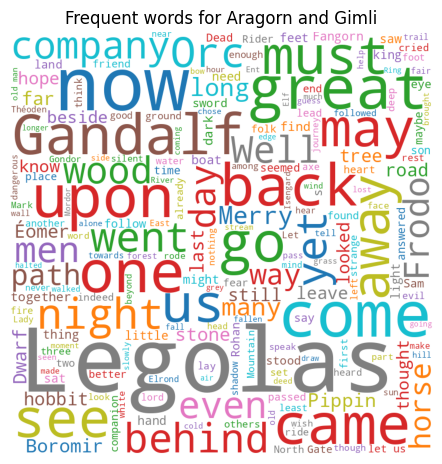

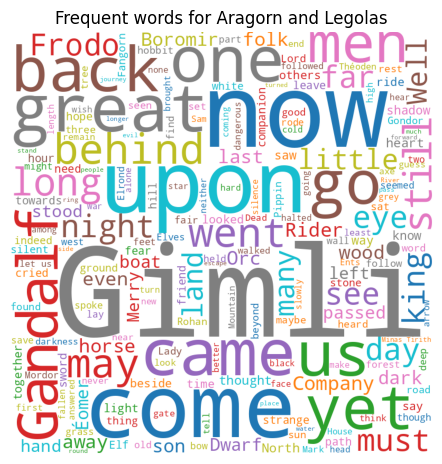

In [ ]:
main_character = 'Aragorn'
words_cloud_ch = ['Arwen', 'Gandalf', 'Gimli', 'Legolas']

for person2 in words_cloud_ch:
    df1 = lotr_network.query(f"person_1 == '{main_character}' and person_2 == '{person2}'")
    df2 = lotr_network.query(f"person_2 == '{main_character}' and person_1 == '{person2}'")

    df = pd.concat([df1, df2], axis = 0)

    plot_word_cloud(df, f'Frequent words for {main_character} and {person2}', main_character, person2)

# Community detection

Community detection is the process of identifying groups of nodes in a graph that are more densely connected to each other than to the rest of the network. These communities often represent real-world clusters such as social circles, functional modules in biological networks, etc.

* Louvain Method is an efficient algorithm for detecting communities
in large networks. It optimizes a measure called modularity, which quantifies the density of edges within communities compared to edges between communities.

* Girvan-Newman algorithm is a hierarchical method for detecting communities in a graph. It identifies groups by progressively removing edges with the highest betweenness centrality, splitting the graph into smaller components. This approach is particularly useful for small to medium-sized graphs.

In [ ]:
df_rel_grouped_short = df_rel_grouped.query('weight > 6')


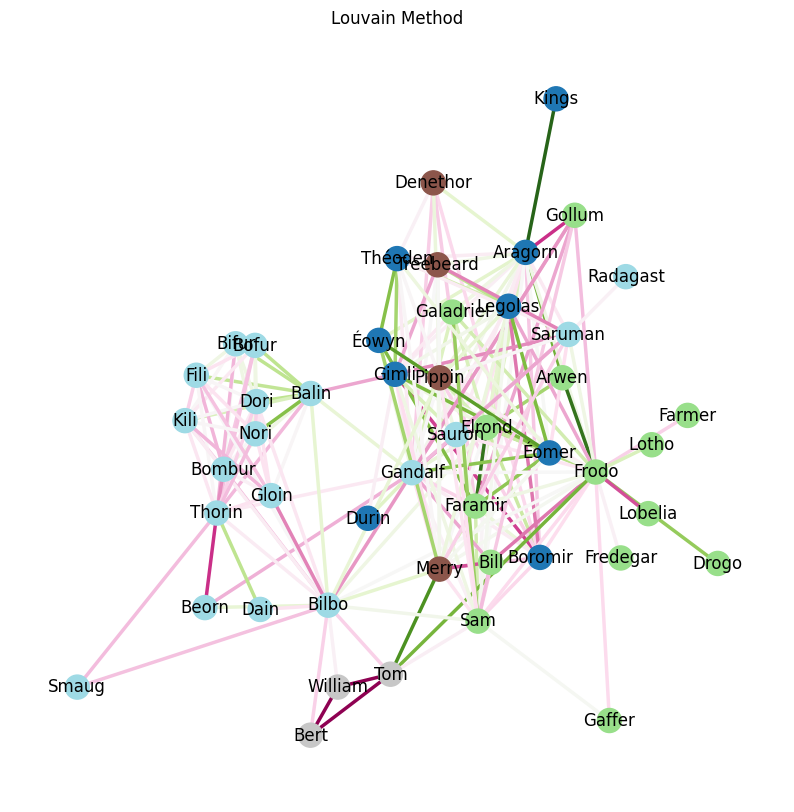

In [ ]:
import networkx as nx
import community.community_louvain as l

G = nx.Graph()

G = nx.from_pandas_edgelist(df_rel_grouped_short, 'person_1', 'person_2', edge_attr=['weight', 'connection_label'])

partition = l.best_partition(G, weight= 'weight')
edge_color = [G[u][v]['connection_label'] for u, v in G.edges()]
# Draw the graph
pos = nx.kamada_kawai_layout(G)
colors = [partition[node] for node in G.nodes()]  # Color nodes by community

plt.figure(figsize=(10, 10))
nx.draw_networkx(G, pos, node_color=colors, cmap=plt.cm.tab20, with_labels=True, edge_color = edge_color, edge_cmap = plt.cm.PiYG, width=2.5)
plt.title("Louvain Method")
plt.axis("off")
plt.show()
plt.show()


In [ ]:
for i in range(5):
    print("community ", i+1)
    print([key for key, value in partition.items() if value == i])

community  1
['Aragorn', 'Boromir', 'Gimli', 'Kings', 'Legolas', 'Théoden', 'Éomer', 'Éowyn', 'Durin']
community  2
['Arwen', 'Elrond', 'Faramir', 'Frodo', 'Gollum', 'Sam', 'Bill', 'Drogo', 'Farmer', 'Fredegar', 'Gaffer', 'Galadriel', 'Lobelia', 'Lotho']
community  3
['Denethor', 'Merry', 'Treebeard', 'Pippin']
community  4
['Bert', 'Tom', 'William']
community  5
['Gandalf', 'Saruman', 'Balin', 'Bifur', 'Bofur', 'Bombur', 'Dori', 'Fili', 'Kili', 'Nori', 'Bilbo', 'Beorn', 'Dain', 'Smaug', 'Sauron', 'Gloin', 'Thorin', 'Radagast']


<Figure size 1000x800 with 0 Axes>

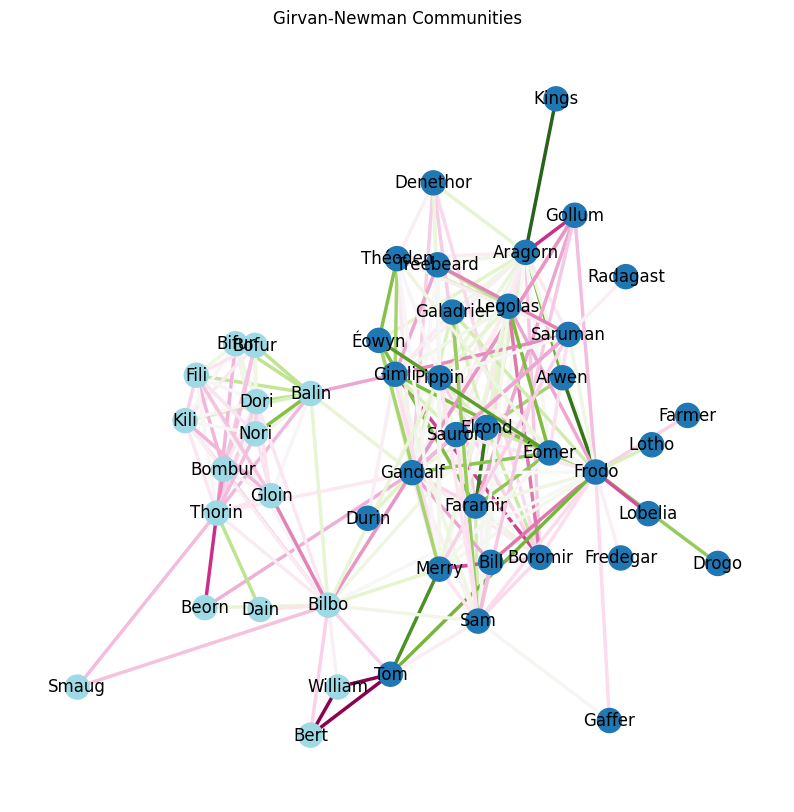

In [ ]:
G = nx.Graph()

df_rel_grouped_short = df_rel_grouped.query('weight > 6')

G = nx.from_pandas_edgelist(df_rel_grouped_short, 'person_1', 'person_2', edge_attr=['weight', 'connection_label'])

communities_generator = girvan_newman(G)
top_level_communities = next(communities_generator)
community_list = list(top_level_communities)

community_colors = {}
for i, community in enumerate(community_list):
    for node in community:
        community_colors[node] = i

colors = [community_colors[node] for node in G.nodes()]
edge_color = [G[u][v]['connection_label'] for u, v in G.edges()]

# Plot the graph
pos = nx.kamada_kawai_layout(G)  # Layout for graph visualization
plt.figure(figsize=(10, 8))

plt.figure(figsize=(10, 10))
nx.draw_networkx(G, pos, node_color=colors, cmap=plt.cm.tab20, with_labels=True, edge_color = edge_color, edge_cmap = plt.cm.PiYG, width=2.5)

plt.title("Girvan-Newman Communities")
plt.axis("off")
plt.show()

In [ ]:
for i in range(3):
    print("community ", i+1)
    print([key for key, value in community_colors.items() if value == i])

community  1
['Éowyn', 'Boromir', 'Fredegar', 'Treebeard', 'Lobelia', 'Gollum', 'Saruman', 'Faramir', 'Éomer', 'Lotho', 'Legolas', 'Tom', 'Frodo', 'Pippin', 'Bill', 'Farmer', 'Arwen', 'Gaffer', 'Sam', 'Denethor', 'Durin', 'Théoden', 'Merry', 'Gimli', 'Sauron', 'Gandalf', 'Elrond', 'Aragorn', 'Galadriel', 'Radagast', 'Kings', 'Drogo']
community  2
['Gloin', 'William', 'Bombur', 'Fili', 'Smaug', 'Dain', 'Bofur', 'Balin', 'Kili', 'Bifur', 'Dori', 'Thorin', 'Bilbo', 'Nori', 'Beorn', 'Bert']
community  3
[]
